In [1]:
from skripsi_program import FourierBasis
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib

Using matplotlib backend: module://matplotlib_inline.backend_inline


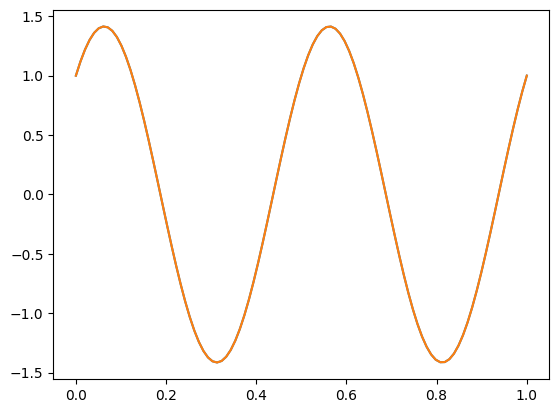

In [19]:
def tmp():
    t = torch.linspace(0,1,100)
    u_sin = t.mul(2*2*torch.pi).cos() + t.mul(2*2*torch.pi).sin()
    u_sin_complex = (1-1j)*t.mul(2*torch.pi*2j).exp()
    plt.plot(t,u_sin)
    plt.plot(t,u_sin_complex.real)
    plt.show()
tmp()

In [2]:
# https://github.com/hplgit/num-methods-for-PDEs/blob/master/src/wave/wave1D/wave1D_u0v.py

def solver(
    I: np.ndarray,
    V: np.ndarray,
    f: np.ndarray,
    BC: np.ndarray,
    c,
    L,
    dt,
    C,
    T,
    user_action=None,
    version="vectorized",
):
    """Solve u_tt=c^2*u_xx + f on (0,L)x(0,T]."""
    Nt = int(round(T / dt))
    t = np.linspace(0, Nt * dt, Nt + 1)  # Mesh points in time
    dx = dt * c / float(C)
    Nx = int(round(L / dx))
    x = np.linspace(0, L, Nx + 1)  # Mesh points in space
    C2 = C**2  # Help variable in the scheme
    #     if f is None or f == 0:
    #         f = (lambda x, t: 0) if version == "scalar" else lambda x, t: np.zeros(x.shape)
    #     if V is None or V == 0:
    #         V = (lambda x: 0) if version == "scalar" else lambda x: np.zeros(x.shape)

    u = np.zeros(Nx + 1)  # Solution array at new time level
    u_1 = np.zeros(Nx + 1)  # Solution at 1 time level back
    u_2 = np.zeros(Nx + 1)  # Solution at 2 time levels back

    t0 = time.perf_counter()  # for measuring CPU time

    # Load initial condition into u_1
    for i in range(0, Nx + 1):
        u_1[i] = I[i]

    if user_action is not None:
        user_action(u_1, x, t, 0)

    # Special formula for first time step
    n = 0
    for i in range(1, Nx):
        u[i] = (
            u_1[i]
            + dt * V[i]
            + 0.5 * C2 * (u_1[i - 1] - 2 * u_1[i] + u_1[i + 1])
            + 0.5 * dt**2 * f[i, n]
        )
    # u[0] = u[1] - dx * BC[0, n + 1]
    # u[-1] = u[-2] + dx * BC[-1, n + 1]
    u[[0,-1]] = BC[:,n+1]

    if user_action is not None:
        user_action(u, x, t, 1)

    # Switch variables before next step
    u_2[:] = u_1
    u_1[:] = u

    for n in range(1, Nt):
        # Update all inner points at time t[n+1]

        if version == "scalar":
            for i in range(1, Nx):
                u[i] = (
                    -u_2[i]
                    + 2 * u_1[i]
                    + C2 * (u_1[i - 1] - 2 * u_1[i] + u_1[i + 1])
                    + dt**2 * f[i, n]
                )
        elif version == "vectorized":  # (1:-1 slice style)
            f_a = f[:, n]  # Precompute in array
            u[1:-1] = (
                -u_2[1:-1]
                + 2 * u_1[1:-1]
                + C2 * (u_1[0:-2] - 2 * u_1[1:-1] + u_1[2:])
                + dt**2 * f_a[1:-1]
            )
        elif version == "vectorized2":  # (1:Nx slice style)
            f_a = f[:, n]  # Precompute in array
            u[1:Nx] = (
                -u_2[1:Nx]
                + 2 * u_1[1:Nx]
                + C2 * (u_1[0 : Nx - 1] - 2 * u_1[1:Nx] + u_1[2 : Nx + 1])
                + dt**2 * f_a[1:Nx]
            )

        # Insert boundary conditions
        # u[0] = u[1] - dx * BC[0, n + 1]
        # u[-1] = u[-2] + dx * BC[-1, n + 1]
        u[[0,-1]] = BC[:,n+1]
        if user_action is not None:
            if user_action(u, x, t, n + 1):
                break

        # Switch variables before next step
        u_2[:] = u_1
        u_1[:] = u

    cpu_time = t0 - time.perf_counter()
    return u, x, t, cpu_time

In [3]:
def stats_display(x: torch.Tensor):
    display(f"diff min: {x.min()}")
    display(f"diff max: {x.max()}")
    display(f"diff mean: {x.mean()}")
    display(f"diff median: {x.median()}")


In [24]:
def test_quadratic():
    """
    Check the scalar and vectorized versions work for
    a quadratic u(x,t)=x(L-x)(1+t/2) that is exactly reproduced.
    """
    L = 1.0
    c = 1.0
    C = 1.0
    Nx = 400  # Very coarse mesh for this exact test
    dt = C * (L / Nx) / c
    T = 1.0

    Nt = int(round(T / dt))
    t = np.linspace(0, Nt * dt, Nt + 1)  # Mesh points in time
    dx = dt * c / float(C)
    Nx = int(round(L / dx))
    x = np.linspace(0, L, Nx + 1).reshape(-1, 1)  # Mesh points in space
    grid_points = [x.flatten(), t.flatten()]
    points_ = np.meshgrid(*grid_points, indexing="ij")
    points_flat = [p.flatten() for p in points_]
    points = np.concatenate([p.reshape((-1, 1)) for p in points_flat], axis=1)
    points = torch.tensor(points)

    # The following function must work for x as array or scalar
    # u_exact = x * (L - x) * (1 + 0.5 * t)
    generator = torch.Generator().manual_seed(4)
    mode = 22
    modes = [mode] * 2
    prod_modes = int(np.prod(modes))
    num_samples = 1
    u_exact_coeff = FourierBasis.generateCoeff(
        num_samples, prod_modes, generator=generator, random_func=torch.rand
    ).view(-1, *modes)
    periods = [T] * len(modes)
    u_exact_basis = FourierBasis(u_exact_coeff, periods)
    u_exact_tensor = u_exact_basis(points).real.view((-1, Nx + 1, Nt + 1))[0]
    u_exact: np.ndarray = u_exact_tensor.numpy()
    # u_exact_tensor = torch.tensor(u_exact)
    display(u_exact.shape)
    # f is a scalar (zeros_like(x) works for scalar x too)
    ut = torch.gradient(u_exact_tensor, spacing=dt, dim=1, edge_order=2)[0]
    ux = torch.gradient(u_exact_tensor, spacing=dx, dim=0, edge_order=2)[0]
    utt = torch.gradient(ut, spacing=dt, dim=1, edge_order=2)[0].numpy()
    uxx = torch.gradient(ux, spacing=dx, dim=0, edge_order=2)[0].numpy()
    IC = u_exact[:, 0]
    V = ut[:, 0].numpy()
    BC = u_exact[[0, -1], :]
    # BC = ux[[0, -1], :].numpy()
    f = utt - c**2 * uxx

    def assert_no_error(u, x, t, n):
        u_e = u_exact[:, n]
        tol = u_exact.std(axis=0).max() * 0.050
        diff: np.ndarray = u - u_e
        diff_abs_max = diff.__abs__().max()
        if diff_abs_max >= tol:
            display(f"n = {n}")
            stats_display(torch.tensor(diff))
            plt.figure(constrained_layout=True, figsize=(16, 6))
            plt.subplot(131)
            plt.plot(u_e)
            plt.title("exact")
            plt.xlabel("x")
            plt.subplot(132)
            plt.plot(u)
            plt.xlabel("x")
            plt.title("fdm")
            plt.subplot(133)
            plt.plot(diff)
            plt.xlabel("x")
            plt.title("diff")
            plt.show()
        assert diff_abs_max < tol

    plt.figure(constrained_layout=True, figsize=(16, 6))
    plt.subplot(131)
    plt.imshow(u_exact)
    plt.title("u")
    plt.xlabel("t")
    plt.ylabel("x")
    plt.colorbar()
    plt.subplot(132)
    plt.imshow(f)
    plt.xlabel("t")
    plt.ylabel("x")
    plt.title("f")
    plt.colorbar()
    plt.subplot(133)
    # plt.imshow(diff)
    # plt.xlabel("t")
    # plt.ylabel("x")
    # plt.title("diff")
    # plt.colorbar()
    plt.show()

    solver(IC, V, f, BC, c, L, dt, C, T, user_action=assert_no_error, version="scalar")
    solver(
        IC, V, f, BC, c, L, dt, C, T, user_action=assert_no_error, version="vectorized"
    )

(401, 401)

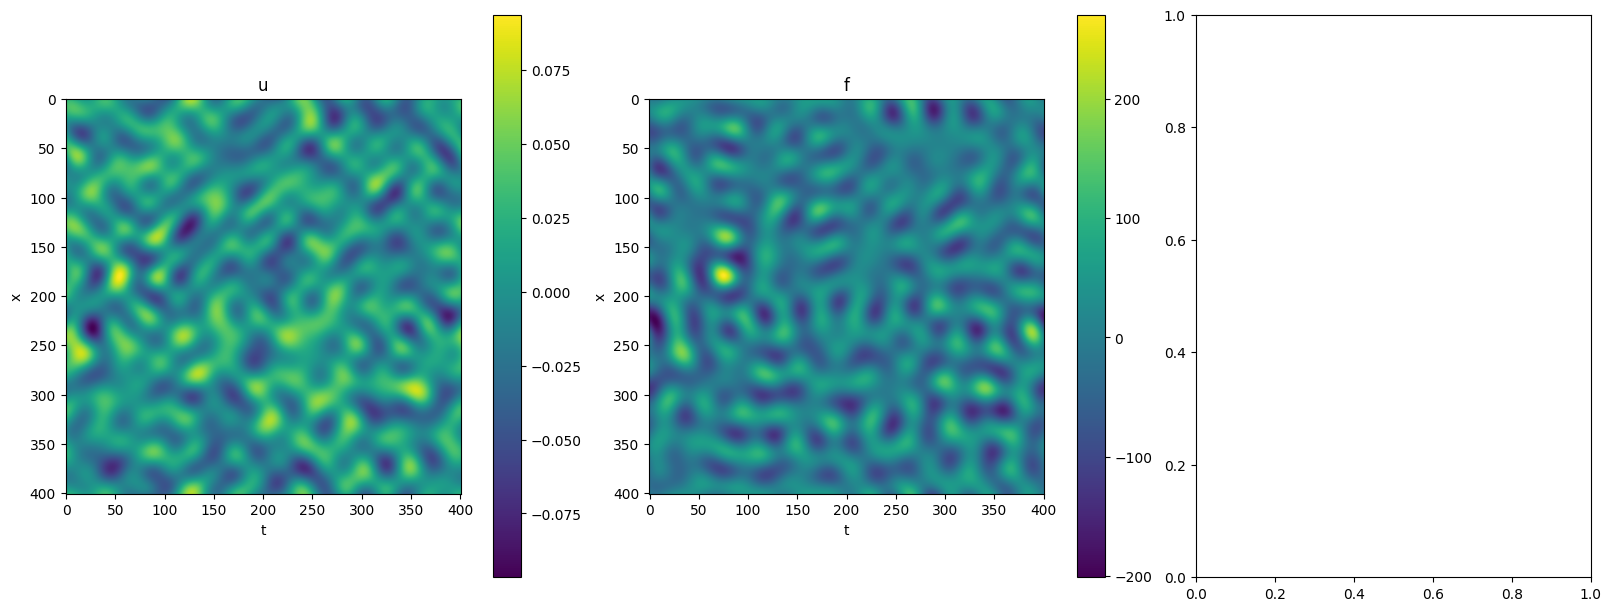

In [25]:
test_quadratic()